In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from tqdm.notebook import tqdm

In [4]:
problem_path = "data/wuf-N1/wuf20-78-N1/wuf20-0305.mwcnf"
soltion_path = "data/wuf-N1/wuf20-78-N-opt.dat"

In [5]:
from satsolver.genetic import GeneticSolver
from satsolver.utils import load_solutions

solutions = load_solutions(soltion_path)

In [6]:
import glob

selected = glob.glob("data/wuf-N1/wuf20-78-N1/*")[:20]

problems = []
for batch_size in [5, 10, 20, 40, 80, 160, 320, 640, 1280]:
    for mutation_rate in [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]:
        for init_type in ["allfalse", "uniform"]:
            for fitness_type in ["sum_or_nothing", "correct_count"]:
                for problem_path in selected:
                    problems.append([batch_size,mutation_rate,problem_path,init_type,fitness_type])

In [9]:
import pandas as pd

rd = pd.DataFrame.from_records(results, columns="batch_size,mutation_rate,solved_time,solved".split(",") )

In [11]:
rd = pd.read_csv("pilot5v3.csv")

In [20]:
init_types = ["allfalse", "uniform"]
fitness_types = ["sum_or_nothing", "correct_count"]

In [21]:
def mutate(p: np.ndarray) -> np.array:
    """Mutate the p array with the preset probability."""
    mutation_mask = (np.random.rand(len(p)) < 0.3).astype("int8")
    return np.where(mutation_mask == 0, p, -p)

IndexError: index 2 is out of bounds for axis 0 with size 2

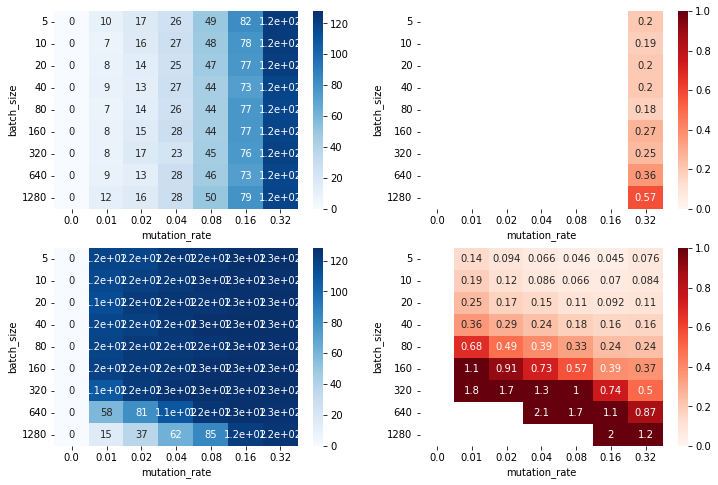

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)

row = 0
for idi, init in enumerate(init_types):
    for idf, fitness in enumerate(fitness_types):
        w = rd[(rd.fitness_type == fitness) & (rd.init_type==init)]
        
        counts = w.groupby(by=["batch_size", "mutation_rate"])["solved_time"].count().unstack()
        means = w.groupby(by=["batch_size", "mutation_rate"])["solved_time"].median().unstack()
        means = (means * (counts > 100)).fillna(0).replace(0, np.nan)
        
        sns.heatmap(counts, annot=True, vmin=0, vmax=128, cmap="Blues", ax=ax[row, 0])
        sns.heatmap(means, annot=True, vmin=0, vmax=1, cmap="Reds", ax=ax[row, 1])
        row += 1

plt.tight_layout(pad=0)
#fig.subplots_adjust(top=0.93)
#fig.suptitle("number of solved instances / median runtime for sum_or_nothing (top) and correct_count (bottom)")
plt.savefig('report5/images/pilot_counts_means.png', bbox_inches='tight')
plt.show()

In [19]:
from tqdm.notebook import tqdm
import time
from bagsolver.genetic import GeneticBagSolver


records = []
start = time.time()
for i in tqdm(range(1000)):
    pool = self.genetic_iteration(pool)
    batch_stats = self.pool_fitness(pool)
    solved = self.solved()
    optscore = self.optscore
    bc = len(batch_stats)
    t = time.time() - start
    records.extend(
        list(zip([i]*bc, [t]*bc, [solved]*bc, [optscore]*bc, batch_stats))
    )
    if t > 10:
        break

In [20]:
import pandas as pd

df = pd.DataFrame(records, columns = ["it", "time", "solved", "optscore", "res"])
df = df.set_index("time")

pf = df.groupby(by="time").agg({"res": ["min", "mean", "max"]})
pf.columns = ["min", "mean", "max"]
pf["best"] = np.maximum.accumulate(pf["max"].values)



 21%|██        | 207/1000 [00:21<00:33, 23.84it/s]

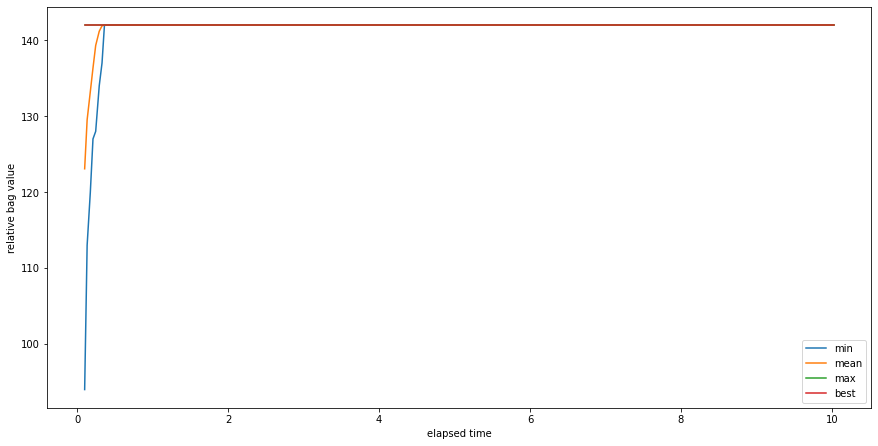

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

pf.plot(ax=ax)
ax.set_xlabel("elapsed time")
ax.set_ylabel("relative bag value")
plt.tight_layout(pad=0)